# Sentiment Analysis Model for Negative Tweets Detection

## Goal:
The purpose of this model is to detect negative tweets from a dataset, which will then be loaded into our database for further review. This sentiment analysis model will use machine learning and natural language processing (NLP) techniques to identify and classify tweets as negative or non-negative.

In the next steps, we will import the necessary libraries and begin building the model.

### Importing Libraries

In this cell, we import various libraries that will help with:

- **Data manipulation**: Using `numpy` and `pandas` for numerical and tabular data.
- **Visualization**: Using `seaborn` and `matplotlib` to create plots that help visualize data.
- **Text preprocessing and tokenization**: The `nltk` library helps clean and tokenize text data, while `sklearn` provides tools for model evaluation.
- **Model creation**: Using TensorFlow/Keras to build and train the LSTM model for sentiment classification.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.cm as cm
from matplotlib import rcParams
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re
import string
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### Downloading NLTK Stopwords

Stopwords are common words such as 'the', 'is', 'in', etc., that do not contribute much meaning to text data. Removing these words helps focus the model on more relevant words for classification. In this step, we download the list of stopwords from the NLTK library.

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Uploading the Dataset

In this step, we use Google Colab's file upload functionality to load the dataset. The uploaded data will be used to train and evaluate the sentiment analysis model.


In [ ]:
# Uploading the dataset
from google.colab import files

uploaded = files.upload()

Saving training.1600000.processed.noemoticon.csv to training.1600000.processed.noemoticon.csv


### Loading and Renaming the Dataset

Here, we load the dataset from the uploaded CSV file using `pandas` and rename the columns for better readability and easier reference throughout the notebook. The dataset contains multiple fields, but we are primarily interested in the `text` column for the tweet content and the `label` column for sentiment classification.

In [ ]:
data = pd.read_csv("/content/training.1600000.processed.noemoticon.csv", encoding = "ISO-8859-1", engine = "python")
data.columns = ["label", "time", "date", "query", "username", "text"]

### Exploring the Dataset

In this step, we take a closer look at the dataset to understand its structure and contents:

- **`data.head()`**: Displays the first few rows of the dataset to check the initial data points.
- **`data.tail()`**: Displays the last few rows to inspect the final entries.
- **`data.columns`**: Lists the column names to ensure they have been renamed correctly.
- **`data.shape`**: Provides the dimensions of the dataset (rows and columns).
- **`data.dtypes`**: Displays the data types of each column to verify that the dataset is loaded correctly.

In [ ]:
# Display the first few rows of the dataset
data.head()

,label,time,date,query,username,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [ ]:
# Display the last few rows of the dataset
data.tail()

,label,time,date,query,username,text
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599998,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


In [ ]:
# List the column names
data.columns

Index(['label', 'time', 'date', 'query', 'username', 'text'], dtype='object')

In [ ]:
# Check the dimensions of the dataset
data.shape

(1599999, 6)

In [ ]:
# Display the data types of each column
data.dtypes

,0
label,int64
time,int64
date,object
query,object
username,object
text,object


### Data Preparation

In this step, we begin preparing the data for sentiment analysis by:

1. **Selecting relevant columns**: We focus only on the `text` and `label` columns.
2. **Converting labels**: The dataset uses the value 4 for positive sentiment, so we convert all instances of label 4 to 1 (positive sentiment) and leave 0 as negative sentiment.
3. **Balancing the dataset**: We take an equal sample of 20,000 positive and 20,000 negative tweets to create a balanced dataset for model training.
4. **Combining the samples**: The positive and negative samples are concatenated into a single dataframe.
5. **Lowercasing text**: We convert all text to lowercase to standardize the input data.
6. **Checking the final rows**: We verify the changes by displaying the last few rows of the `text` column.

In [ ]:
# Step 1: Selecting relevant columns
data = data [['text', 'label']]

In [ ]:
# Step 2: Converting label 4 to 1 (positive sentiment)
data['label'][data['label']==4]=1

In [ ]:
# Step 3: Creating separate datasets for positive and negative sentiment
data_pos = data[data['label'] == 1]
data_neg = data[data['label'] == 0]

In [ ]:
# Step 4: Taking a balanced sample of 20,000 positive and 20,000 negative tweets
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]

In [ ]:
# Step 5: Combining positive and negative samples
data = pd.concat([data_pos, data_neg])

In [ ]:
# Step 6: Lowercasing all text data
data['text']=data['text'].str.lower()

In [ ]:
# Step 7: Displaying the last few rows of the 'text' column to verify changes
data['text'].tail()

,text
19995,one more day of holidays
19996,feeling so down right now .. i hate you damn h...
19997,"geez,i hv to read the whole book of personalit..."
19998,i threw my sign at donnie and he bent over to ...
19999,@heather2711 good thing i didn't find any then...


### Text Data Cleaning

Now, we proceed to clean the text data. This step is crucial for removing unnecessary elements that don't contribute to the sentiment analysis task. We perform the following cleaning tasks:

1. **Removing stopwords**: Common words (like 'the', 'is', 'in') that do not carry significant meaning are removed.
2. **Removing punctuations**: All punctuation marks are removed as they don't contribute to the meaning for sentiment classification.
3. **Removing repeating characters**: We eliminate repeated characters (e.g., 'heyyy' becomes 'hey') to simplify the text.
4. **Removing emails**: Any email addresses in the text are removed to avoid noise in the data.
5. **Removing URLs**: Links and URLs are removed since they are not useful for sentiment analysis.
6. **Removing numbers**: Numbers are removed from the text as they typically don't help in determining sentiment.

In [ ]:
# Step 1: Removing stopwords
stopwords_list = stopwords.words('english')

In [ ]:
# Displaying stopwords to understand what's being removed
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))

In [ ]:
# Removing stopwords from the dataset
STOPWORDS = set(stopwords.words('english'))
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
data['text'] = data['text'].apply(lambda text: cleaning_stopwords(text))
data['text'].head()

,text
799999,love @health4uandpets u guys r best!!
800000,im meeting one besties tonight! cant wait!! - ...
800001,"@darealsunisakim thanks twitter add, sunisa! g..."
800002,sick really cheap hurts much eat real food plu...
800003,@lovesbrooklyn2 effect everyone


In [19]:
# Step 2: Removing punctuations
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

In [20]:
data['text']= data['text'].apply(lambda x: cleaning_punctuations(x))
data['text'].tail()

,text
19995,one day holidays
19996,feeling right hate damn humprey
19997,geezi hv read whole book personality types emb...
19998,threw sign donnie bent get thingee made sad face
19999,heather2711 good thing find none ones like com...


In [21]:
# Step 3: Removing repeating characters
def cleaning_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

In [22]:
data['text'] = data['text'].apply(lambda x: cleaning_repeating_char(x))
data['text'].tail()

,text
19995,one day holidays
19996,feling right hate damn humprey
19997,gezi hv read whole bok personality types embar...
19998,threw sign donie bent get thinge made sad face
19999,heather271 god thing find none ones like come ...


In [23]:
# Step 4: Removing email addresses
def cleaning_email(data):
    return re.sub('@[^\s]+', ' ', data)

In [24]:
data['text']= data['text'].apply(lambda x: cleaning_email(x))
data['text'].tail()

,text
19995,one day holidays
19996,feling right hate damn humprey
19997,gezi hv read whole bok personality types embar...
19998,threw sign donie bent get thinge made sad face
19999,heather271 god thing find none ones like come ...


In [25]:
# Step 5: Removing URLs
def cleaning_URLs(data):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',data)

In [26]:
data['text'] = data['text'].apply(lambda x: cleaning_URLs(x))
data['text'].tail()

,text
19995,one day holidays
19996,feling right hate damn humprey
19997,gezi hv read whole bok personality types embar...
19998,threw sign donie bent get thinge made sad face
19999,heather271 god thing find none ones like come ...


In [27]:
# Step 6: Removing numbers
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)

In [28]:
data['text'] = data['text'].apply(lambda x: cleaning_numbers(x))
data['text'].tail()

,text
19995,one day holidays
19996,feling right hate damn humprey
19997,gezi hv read whole bok personality types embar...
19998,threw sign donie bent get thinge made sad face
19999,heather god thing find none ones like come siz...


### Tokenization, Stemming, Lemmatization, and Data Preparation

In this section, we further process the text data by:

1. **Tokenization**: We split the text into individual words (tokens) using a regular expression-based tokenizer.
2. **Stemming**: We apply stemming to reduce words to their root form (e.g., 'running' becomes 'run'), simplifying the vocabulary.
3. **Lemmatization**: We apply lemmatization, which is similar to stemming but results in more linguistically accurate base forms of words.
4. **Data Preparation for the Model**: We then prepare the data for model training:
    - We split the data into features (`X`) and labels (`y`).
    - We convert the tokenized text into sequences using `Tokenizer`.
    - Finally, we pad the sequences to ensure they are of the same length, which is required for the model.

In [29]:
# Step 1: Tokenizing the text
tokenizer = RegexpTokenizer(r'\w+')
data['text'] = data['text'].apply(tokenizer.tokenize)

In [30]:
# Displaying the tokenized text
data['text'].head()

,text
799999,"[love, healthuandpets, u, guys, r, best]"
800000,"[im, meting, one, besties, tonight, cant, wait..."
800001,"[darealsunisakim, thanks, twiter, ad, sunisa, ..."
800002,"[sick, realy, cheap, hurts, much, eat, real, f..."
800003,"[lovesbroklyn, efect, everyone]"


In [31]:
# Step 2: Stemming the text
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data

data['text']= data['text'].apply(lambda x: stemming_on_text(x))

In [32]:
# Displaying the stemmed text
data['text'].head()

,text
799999,"[love, healthuandpets, u, guys, r, best]"
800000,"[im, meting, one, besties, tonight, cant, wait..."
800001,"[darealsunisakim, thanks, twiter, ad, sunisa, ..."
800002,"[sick, realy, cheap, hurts, much, eat, real, f..."
800003,"[lovesbroklyn, efect, everyone]"


In [34]:
# Step 3: Downloading WordNet corpus for lemmatization
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [35]:
# Step 4: Lemmatizing the text
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data

data['text'] = data['text'].apply(lambda x: lemmatizer_on_text(x))

In [36]:
# Displaying the lemmatized text
data['text'].head()

,text
799999,"[love, healthuandpets, u, guys, r, best]"
800000,"[im, meting, one, besties, tonight, cant, wait..."
800001,"[darealsunisakim, thanks, twiter, ad, sunisa, ..."
800002,"[sick, realy, cheap, hurts, much, eat, real, f..."
800003,"[lovesbroklyn, efect, everyone]"


In [37]:
# Step 5: Preparing the data for model training (splitting features and labels)
X=data.text
y=data.label

In [38]:
# Step 6: Tokenizing and padding the sequences
max_len = 500
tok = Tokenizer(num_words=2000)
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [39]:
# Checking the shape of the prepared data
sequences_matrix.shape

(40000, 500)

### Model Training and Evaluation

In this section, we build and train the sentiment analysis model using a Long Short-Term Memory (LSTM) network. The steps include:

1. **Splitting the data**: We split the data into training and testing sets to evaluate the model's performance on unseen data.
2. **Building the model**: We define a TensorFlow-based LSTM model. This model processes the sequences and performs binary classification (positive or negative sentiment).
3. **Compiling the model**: We compile the model with a binary cross-entropy loss function and RMSprop optimizer.
4. **Training the model**: We train the model with the training data for a specified number of epochs.
5. **Evaluating the model**: We test the model on the test dataset and calculate the accuracy.
6. **Confusion Matrix**: We visualize the confusion matrix to analyze the model's performance in classifying positive and negative tweets.
7. **ROC Curve**: We plot the ROC (Receiver Operating Characteristic) curve to understand the trade-off between true positive rate and false positive rate.

In [40]:
# Step 1: Splitting the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(sequences_matrix, y, test_size=0.3, random_state=2)

In [41]:
# Step 2: Building the TensorFlow-based LSTM model
def tensorflow_based_model(): #Defined tensorflow_based_model function for training tenforflow based model
    inputs = Input(name='inputs',shape=[max_len])#step1
    layer = Embedding(2000,50,input_length=max_len)(inputs) #step2
    layer = LSTM(64)(layer) #step3
    layer = Dense(256,name='FC1')(layer) #step4
    layer = Activation('relu')(layer) # step5
    layer = Dropout(0.5)(layer) # step6
    layer = Dense(1,name='out_layer')(layer) #step4 again but this time its giving only one output as because we need to classify the tweet as positive or negative
    layer = Activation('sigmoid')(layer) #step5 but this time activation function is sigmoid for only one output.
    model = Model(inputs=inputs,outputs=layer) #here we are getting the final output value in the model for classification
    return model #function returning the value when we call it

In [42]:
# Step 3: Compiling the model
model = tensorflow_based_model() # here we are calling the function of created model
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

In [43]:
# Step 4: Training the model
history=model.fit(X_train,Y_train,batch_size=80,epochs=6, validation_split=0.1)# here we are starting the training of model by feeding the training data
print('Training finished !!')

Epoch 1/6
315/315 ━━━━━━━━━━━━━━━━━━━━ 156s 486ms/step - accuracy: 0.5746 - loss: 0.6631 - val_accuracy: 0.7371 - val_loss: 0.5271
Epoch 2/6
315/315 ━━━━━━━━━━━━━━━━━━━━ 205s 497ms/step - accuracy: 0.7500 - loss: 0.5117 - val_accuracy: 0.6668 - val_loss: 0.5953
Epoch 3/6
315/315 ━━━━━━━━━━━━━━━━━━━━ 151s 478ms/step - accuracy: 0.7550 - loss: 0.5068 - val_accuracy: 0.7421 - val_loss: 0.5233
Epoch 4/6
315/315 ━━━━━━━━━━━━━━━━━━━━ 206s 490ms/step - accuracy: 0.7661 - loss: 0.4937 - val_accuracy: 0.7454 - val_loss: 0.5175
Epoch 5/6
315/315 ━━━━━━━━━━━━━━━━━━━━ 150s 476ms/step - accuracy: 0.7699 - loss: 0.4804 - val_accuracy: 0.7468 - val_loss: 0.5175
Epoch 6/6
315/315 ━━━━━━━━━━━━━━━━━━━━ 150s 478ms/step - accuracy: 0.7772 - loss: 0.4751 - val_accuracy: 0.7411 - val_loss: 0.5316
Training finished !!


In [44]:
# Step 5: Evaluating the model on test data
accr1 = model.evaluate(X_test,Y_test) #we are starting to test the model here

375/375 ━━━━━━━━━━━━━━━━━━━━ 31s 82ms/step - accuracy: 0.7389 - loss: 0.5300


In [45]:
print('Test set\n  Accuracy: {:0.2f}'.format(accr1[1])) #the accuracy of the model on test data is given below

Test set
  Accuracy: 0.74


In [46]:
# Step 6: Making predictions and displaying the confusion matrix
y_pred = model.predict(X_test) #getting predictions on the trained model
y_pred = (y_pred > 0.5)

375/375 ━━━━━━━━━━━━━━━━━━━━ 31s 83ms/step




confusion matrix


[[4337 1672]
 [1398 4593]]




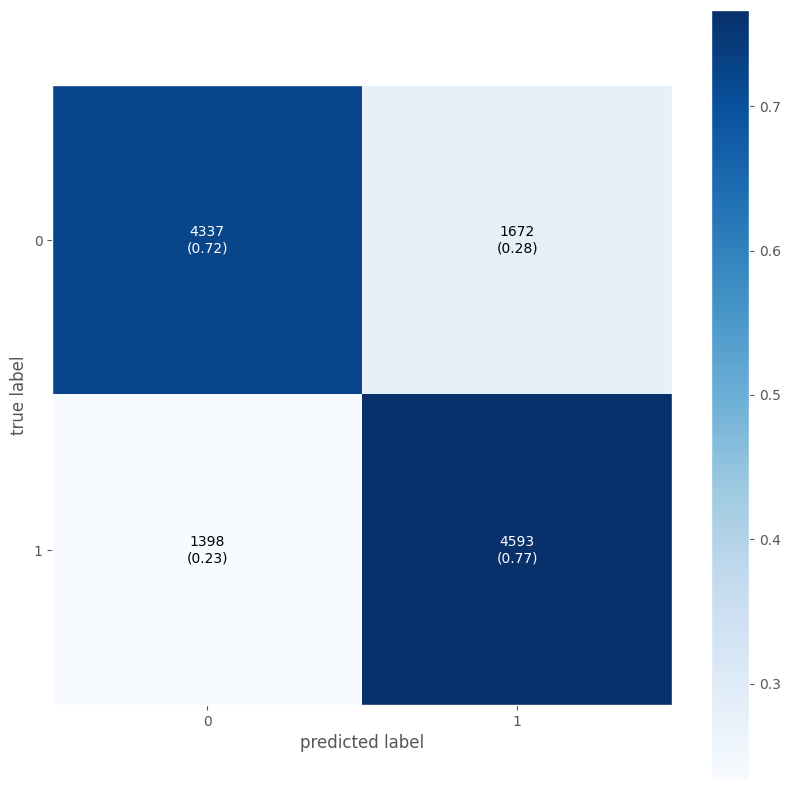

In [47]:
print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(Y_test, y_pred)
print(CR)
print('\n')

# Plotting the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

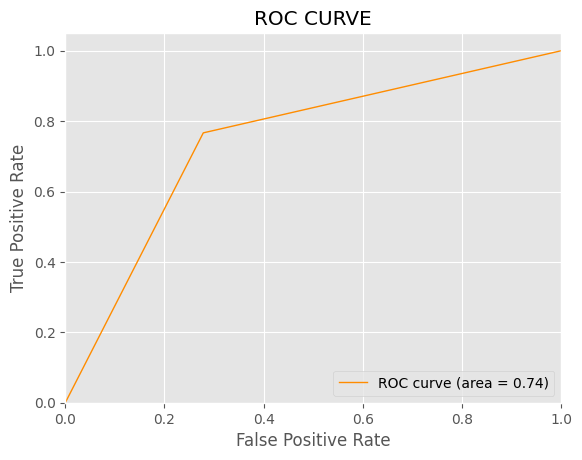

In [48]:
# Step 7: Plotting the ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()